In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scripts.helpers as helpers

helpers.add_backend_to_path()

In [225]:
import pymongo
from pymongo import MongoClient
from dotenv import load_dotenv
load_dotenv()
import os

connection_string = os.getenv("MONGO_CONNECTION_STRING")

client = MongoClient(connection_string)
db = client.get_database("course_feedback")

db.recommendation_feedback.create_index([("user_id", pymongo.ASCENDING)])
db.recommendation_feedback.create_index([("course", pymongo.ASCENDING)])
db.user_feedback.create_index([("faculty", pymongo.ASCENDING)])

print("Connected to MongoDB")

Connected to MongoDB


In [226]:
import numpy as np
rec_feedbacks = list(db.recommendation_feedback.find())

# Convert to DataFrame
rec_data = []
for feedback in rec_feedbacks:
    rec_data.append({
        'user_id': feedback['user_id'],
        'action': feedback['action'],
        'model': feedback['model'],
        'course': feedback['course'],
        'liked': feedback.get('liked_recommendations', []),
        'disliked': feedback.get('disliked_recommendations', []), 
        'skipped': feedback.get('skipped_recommendations', []),
        'phrases': feedback.get('phrases', []),
        'recommended_from': feedback.get('recommended_from', []),
        'timestamp': feedback['timestamp']
    })
rec_df = pd.DataFrame(rec_data)

print(rec_df.head())


                                user_id action                  model  course  \
0  832e69de-3160-4f9e-ab18-6500be557613   skip  max_with_combinations  JPN112   
1  832e69de-3160-4f9e-ab18-6500be557613   skip  max_with_combinations  DSMA06   
2  832e69de-3160-4f9e-ab18-6500be557613   skip  max_with_combinations  JPN122   
3  832e69de-3160-4f9e-ab18-6500be557613   skip  max_with_combinations  JPNN11   
4  832e69de-3160-4f9e-ab18-6500be557613   like  max_with_combinations  JPNN30   

                                               liked disliked  \
0  [LgBB01, DSMB23, PB009, p9045, IB015, PB016, P...  [IB111]   
1  [LgBB01, DSMB23, PB009, p9045, IB015, PB016, P...  [IB111]   
2  [LgBB01, DSMB23, PB009, p9045, IB015, PB016, P...  [IB111]   
3  [LgBB01, DSMB23, PB009, p9045, IB015, PB016, P...  [IB111]   
4  [LgBB01, DSMB23, PB009, p9045, IB015, PB016, P...  [IB111]   

                            skipped phrases  recommended_from  \
0                                []      []          [JPN

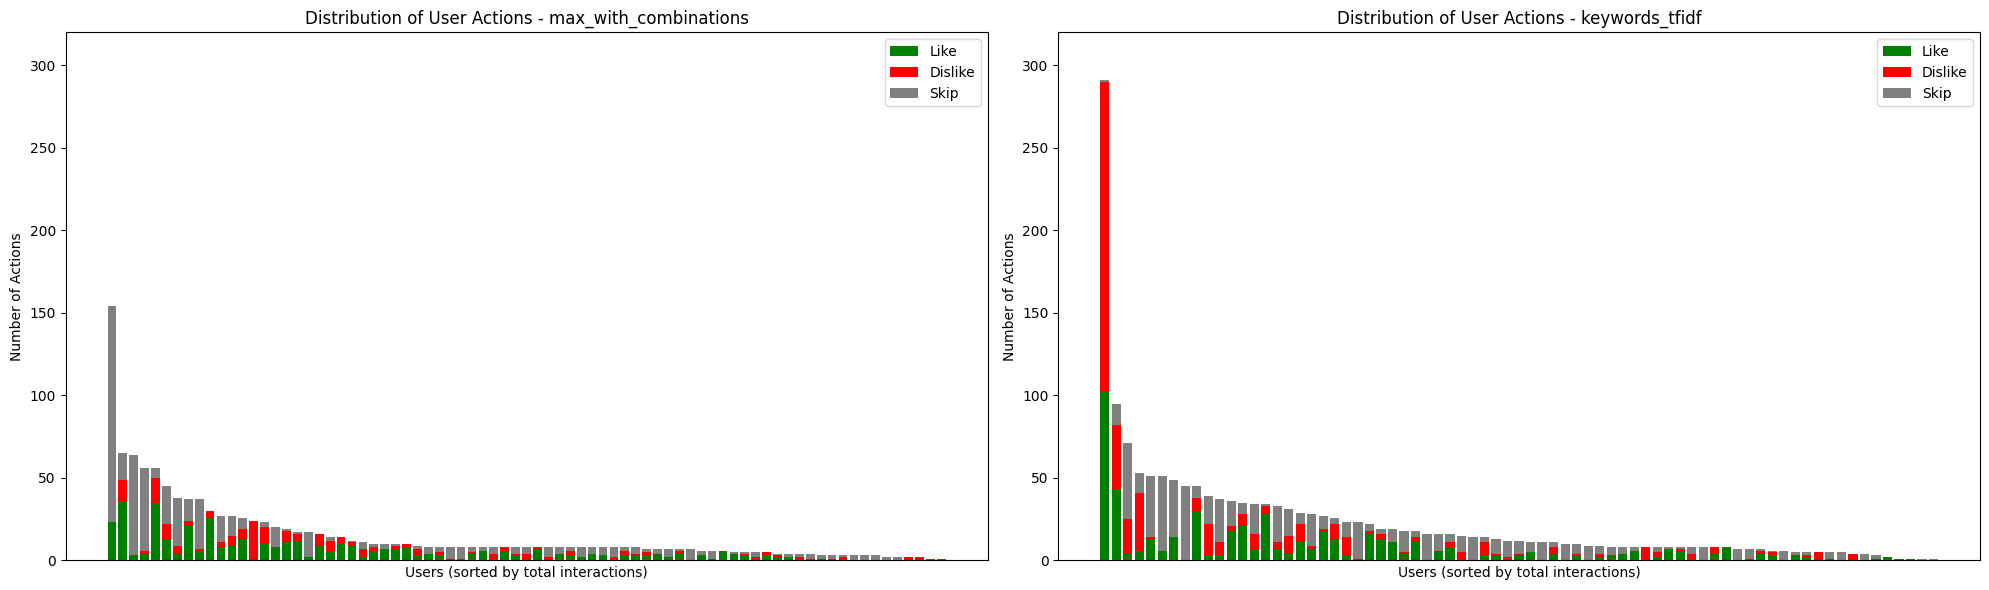


Statistics for max_with_combinations:
Number of users: 77

Average number of actions per user:
action
dislike    2.47
like       5.32
skip       7.47
dtype: float64

Total interactions per user:
count     77.00
mean      15.26
std       21.56
min        1.00
25%        5.00
50%        8.00
75%       16.00
max      154.00
dtype: float64

Statistics for keywords_tfidf:
Number of users: 73

Average number of actions per user:
action
dislike    6.34
like       7.01
skip       9.16
dtype: float64

Total interactions per user:
count     73.00
mean      22.52
std       36.43
min        1.00
25%        8.00
50%       12.00
75%       28.00
max      291.00
dtype: float64


In [227]:
def plot_user_actions():
    # Group by user_id, model and action to get counts
    user_stats = rec_df.groupby(['user_id', 'model', 'action']).size().unstack(fill_value=0)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    
    # Get unique models
    models = rec_df['model'].unique()
    
    # Find the maximum y-value across all models for consistent scaling
    max_y = 0
    for model in models:
        model_data = user_stats.xs(model, level='model')
        total_interactions = model_data.sum(axis=1)
        max_y = max(max_y, total_interactions.max())
    
    # Plot for each model
    for idx, model in enumerate(models):
        # Filter data for current model
        model_data = user_stats.xs(model, level='model')
        
        # Sort users by total interactions
        total_interactions = model_data.sum(axis=1)
        model_data = model_data.loc[total_interactions.sort_values(ascending=False).index]
        
        # Create stacked bars
        bottom = np.zeros(len(model_data))
        colors = {'like': 'green', 'dislike': 'red', 'skip': 'grey'}
        
        for action in ['like', 'dislike', 'skip']:
            if action in model_data.columns:
                ax = ax1 if idx == 0 else ax2
                ax.bar(range(len(model_data)), 
                      model_data[action], 
                      bottom=bottom,
                      label=action.capitalize(),
                      color=colors[action])
                bottom += model_data[action]
        
        # Customize subplot
        ax = ax1 if idx == 0 else ax2
        ax.set_xlabel('Users (sorted by total interactions)')
        ax.set_ylabel('Number of Actions')
        ax.set_title(f'Distribution of User Actions - {model}')
        ax.legend()
        ax.set_xticks([])  # Hide x-axis labels since there are many users
        ax.set_ylim(0, int(max_y*1.1))  # Set same y-axis limit for both plots
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics for each model
    for model in models:
        model_data = user_stats.xs(model, level='model')
        total_interactions = model_data.sum(axis=1)
        
        print(f"\nStatistics for {model}:")
        print("Number of users:", len(model_data))
        print("\nAverage number of actions per user:")
        print(model_data.mean().round(2))
        print("\nTotal interactions per user:")
        print(total_interactions.describe().round(2))

plot_user_actions()


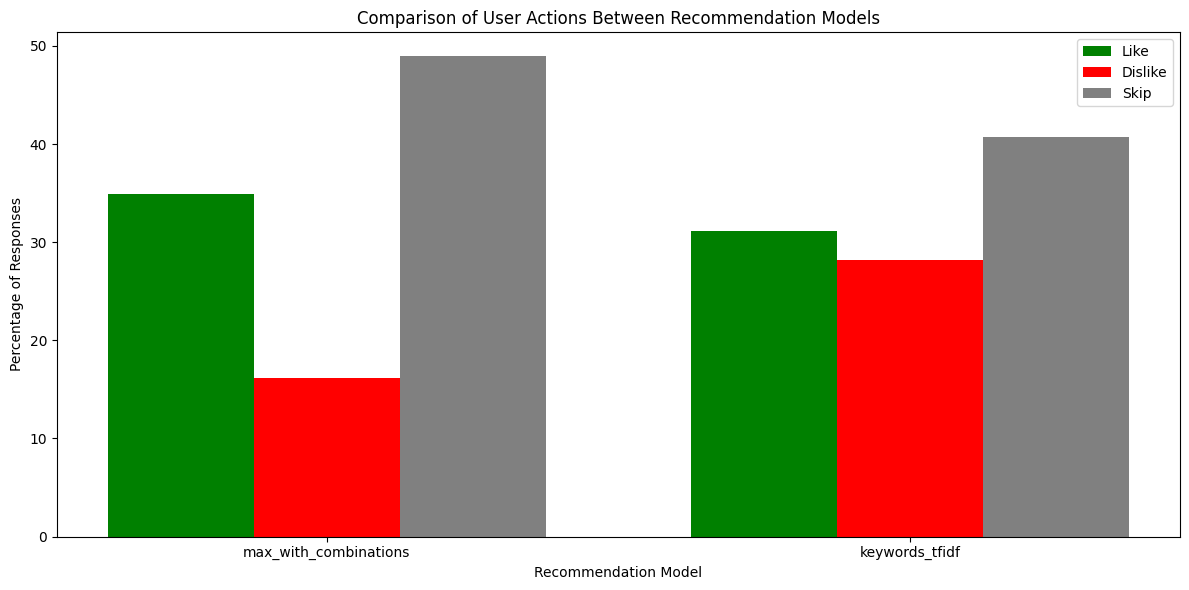


Number of unique users per model:
model
keywords_tfidf           73
max_with_combinations    77
Name: user_id, dtype: int64

Total number of interactions per model:
model
keywords_tfidf           1644
max_with_combinations    1175
dtype: int64

Average interactions per user for each model:
model
keywords_tfidf           22.52
max_with_combinations    15.26
dtype: float64

Raw numbers of actions per model:
action                 dislike  like  skip
model                                     
max_with_combinations      190   410   575
keywords_tfidf             463   512   669

Percentage distribution of actions per model:
action                 dislike   like   skip
model                                       
max_with_combinations    16.17  34.89  48.94
keywords_tfidf           28.16  31.14  40.69


In [228]:
def plot_actions_percentage():
    # Group by model and action to get counts
    model_stats = rec_df.groupby(['model', 'action']).size().unstack(fill_value=0)
    
    # Reorder models to put max_with_combinations first
    model_stats = model_stats.reindex(['max_with_combinations', 'keywords_tfidf'])

    # Calculate percentages for each model
    model_percentages = model_stats.div(model_stats.sum(axis=1), axis=0) * 100

    # Plot comparison
    plt.figure(figsize=(12, 6))

    # Create grouped bar chart
    x = np.arange(len(model_stats.index))
    width = 0.25

    for i, action in enumerate(['like', 'dislike', 'skip']):
        if action in model_percentages.columns:
            color = 'green' if action == 'like' else 'red' if action == 'dislike' else 'grey'
            plt.bar(x + i*width, model_percentages[action], width, 
                    label=action.capitalize(), color=color)

    plt.xlabel('Recommendation Model')
    plt.ylabel('Percentage of Responses')
    plt.title('Comparison of User Actions Between Recommendation Models')
    plt.xticks(x + width, model_stats.index)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Calculate unique users per model
    unique_users = rec_df.groupby('model')['user_id'].nunique()
    print("\nNumber of unique users per model:")
    print(unique_users)

    # Calculate total interactions per model
    total_interactions = rec_df.groupby('model').size()
    print("\nTotal number of interactions per model:")
    print(total_interactions)

    # Calculate average interactions per user for each model
    avg_interactions = total_interactions / unique_users
    print("\nAverage interactions per user for each model:")
    print(avg_interactions.round(2))
    print("\nRaw numbers of actions per model:")
    print(model_stats)
    print("\nPercentage distribution of actions per model:")
    print(model_percentages.round(2))

plot_actions_percentage()

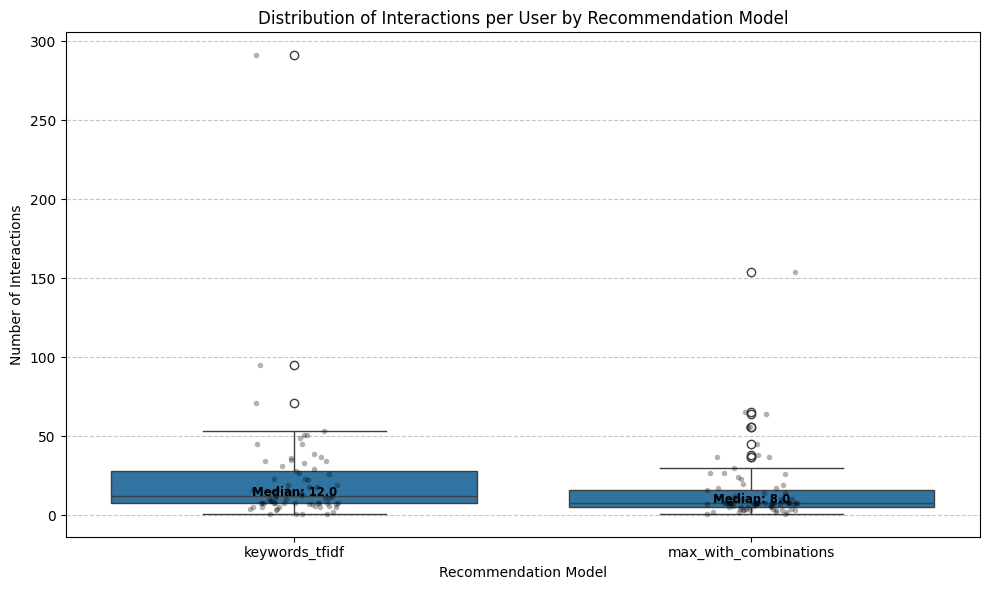

In [229]:
def boxplot_actions_model():
    # Create a boxplot showing the distribution of interactions per user for each model
    plt.figure(figsize=(10, 6))

    # Calculate number of interactions per user for each model
    interactions_per_user = rec_df.groupby(['model', 'user_id']).size().reset_index(name='interactions')

    # Create the boxplot
    sns.boxplot(x='model', y='interactions', data=interactions_per_user)

    # Add individual data points with jitter for better visibility
    sns.stripplot(x='model', y='interactions', data=interactions_per_user, 
                size=4, color='black', alpha=0.3, jitter=True)

    # Add labels and title
    plt.title('Distribution of Interactions per User by Recommendation Model')
    plt.xlabel('Recommendation Model')
    plt.ylabel('Number of Interactions')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Calculate and display median values
    medians = interactions_per_user.groupby('model')['interactions'].median()
    for i, model in enumerate(medians.index):
        plt.text(i, medians[model], f'Median: {medians[model]:.1f}', 
                horizontalalignment='center', size='small', color='black', weight='semibold')

    plt.tight_layout()
    plt.show()
boxplot_actions_model()

In [230]:
# Filter out users with more than 75 actions and users with only one type of action
user_action_counts = rec_df.groupby('user_id').size()
action_types = rec_df.groupby('user_id')['action'].nunique()

# Keep users with 4-75 actions and multiple action types
users_to_keep = user_action_counts[
    (user_action_counts > 3) & 
    (user_action_counts <= 75) & 
    (action_types > 1)
].index

# Create filtered dataframe
filtered_rec_df = rec_df[rec_df['user_id'].isin(users_to_keep)]

# Print information about filtered users
filtered_out_users = len(rec_df['user_id'].unique()) - len(users_to_keep)
filtered_out_actions = len(rec_df) - len(filtered_rec_df)

print(f"\nFiltered out {filtered_out_users} users with more than 75 actions, less than 4 actions, or only one type of action")
print(f"Removed {filtered_out_actions} actions ({filtered_out_actions/len(rec_df)*100:.2f}% of total)")
print(f"Remaining users: {len(filtered_rec_df['user_id'].unique())}")

# Update rec_df to use filtered data
rec_df = filtered_rec_df


Filtered out 35 users with more than 75 actions, less than 4 actions, or only one type of action
Removed 738 actions (26.18% of total)
Remaining users: 114


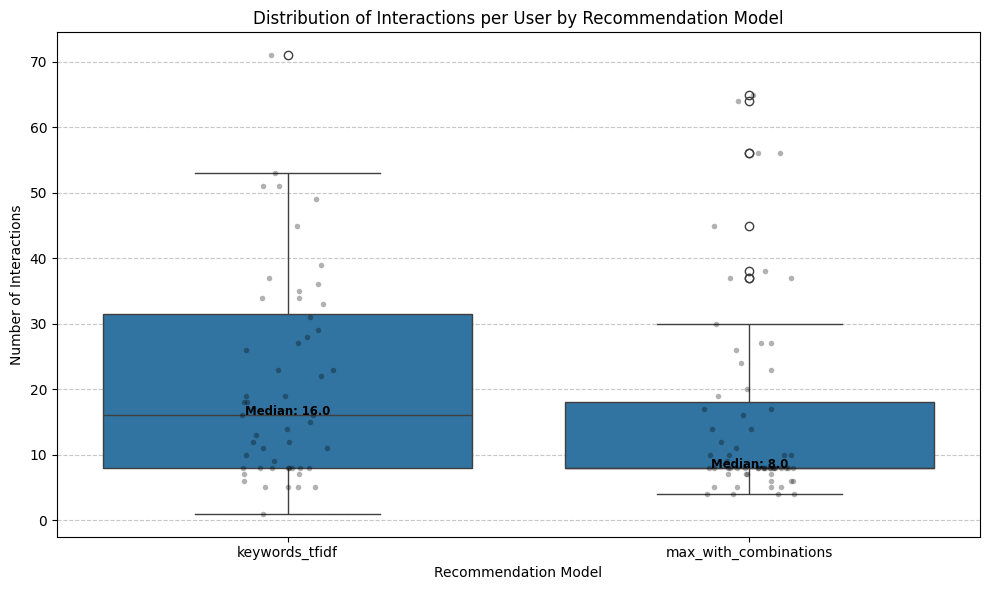

In [231]:
boxplot_actions_model()

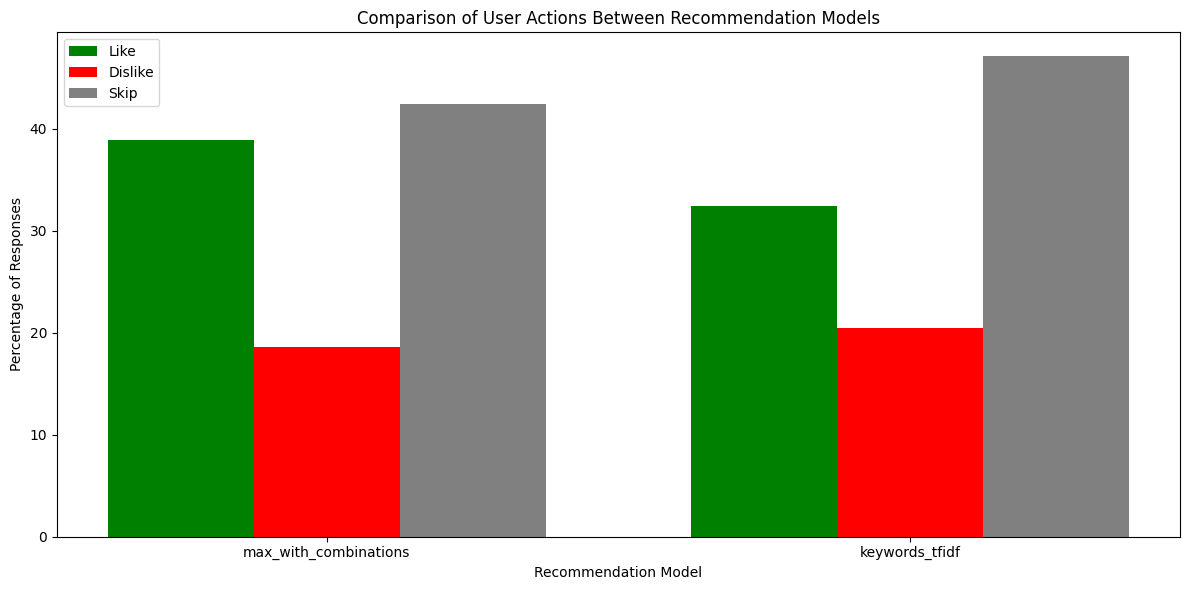


Number of unique users per model:
model
keywords_tfidf           52
max_with_combinations    63
Name: user_id, dtype: int64

Total number of interactions per model:
model
keywords_tfidf           1095
max_with_combinations     986
dtype: int64

Average interactions per user for each model:
model
keywords_tfidf           21.06
max_with_combinations    15.65
dtype: float64

Raw numbers of actions per model:
action                 dislike  like  skip
model                                     
max_with_combinations      183   384   419
keywords_tfidf             224   355   516

Percentage distribution of actions per model:
action                 dislike   like   skip
model                                       
max_with_combinations    18.56  38.95  42.49
keywords_tfidf           20.46  32.42  47.12


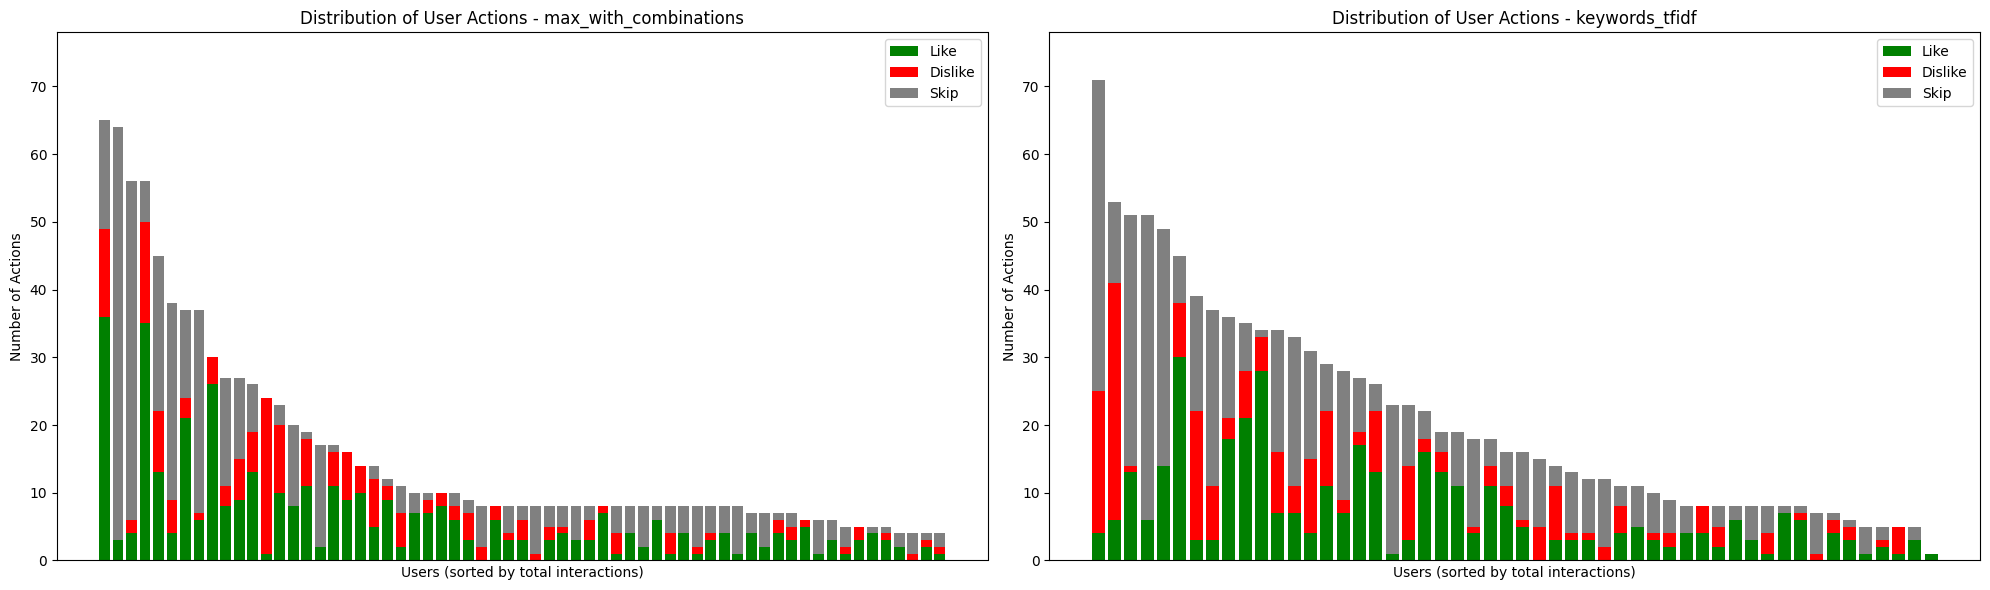


Statistics for max_with_combinations:
Number of users: 63

Average number of actions per user:
action
dislike    2.90
like       6.10
skip       6.65
dtype: float64

Total interactions per user:
count    63.00
mean     15.65
std      15.02
min       4.00
25%       8.00
50%       8.00
75%      18.00
max      65.00
dtype: float64

Statistics for keywords_tfidf:
Number of users: 52

Average number of actions per user:
action
dislike    4.31
like       6.83
skip       9.92
dtype: float64

Total interactions per user:
count    52.00
mean     21.06
std      15.78
min       1.00
25%       8.00
50%      16.00
75%      31.50
max      71.00
dtype: float64


In [232]:
plot_actions_percentage()
plot_user_actions()

In [233]:
# Get initial preferences from first interaction of each user
first_interactions = rec_df.sort_values('timestamp').groupby('user_id').first()

# Initialize sets for initially liked and disliked courses
initial_likes_set = set()
initial_dislikes_set = set()

# Initialize dictionaries to count likes and dislikes per course
initial_likes_counts = {}
initial_dislikes_counts = {}

total_likes = 0
total_dislikes = 0

# Combine liked and disliked courses from first interactions
for _, row in first_interactions.iterrows():
    if isinstance(row['liked'], list):
        initial_likes_set.update(row['liked'])
        for course in row['liked']:
            initial_likes_counts[course] = initial_likes_counts.get(course, 0) + 1
            total_likes += 1
    if isinstance(row['disliked'], list):    
        initial_dislikes_set.update(row['disliked'])
        for course in row['disliked']:
            initial_dislikes_counts[course] = initial_dislikes_counts.get(course, 0) + 1
            total_dislikes += 1

print("\nInitial preferences analysis:")
print(f"Number of initially liked courses: {len(initial_likes_set)}")
print(f"Number of initially disliked courses: {len(initial_dislikes_set)}")
print(f"Number of courses with initial preferences: {len(initial_likes_set | initial_dislikes_set)}")
print(f"Number of courses both liked and disliked: {len(initial_likes_set & initial_dislikes_set)}")

print("\nCourses with most likes:")
for course, count in sorted(initial_likes_counts.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"{course}: {count} likes")

print("\nCourses with most dislikes:")
for course, count in sorted(initial_dislikes_counts.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"{course}: {count} dislikes")



Initial preferences analysis:
Number of initially liked courses: 227
Number of initially disliked courses: 75
Number of courses with initial preferences: 262
Number of courses both liked and disliked: 40

Courses with most likes:
IB111: 24 likes
IB002: 22 likes
PB071: 16 likes
IB015: 15 likes
IB031: 14 likes

Courses with most dislikes:
PB152: 16 dislikes
PB156: 15 dislikes
PV080: 8 dislikes
IB000: 8 dislikes
PB007: 7 dislikes


In [234]:
from app.courses import CourseClient

course_client = CourseClient(os.path.join("..", "web", "backend", "assets", "courses"))

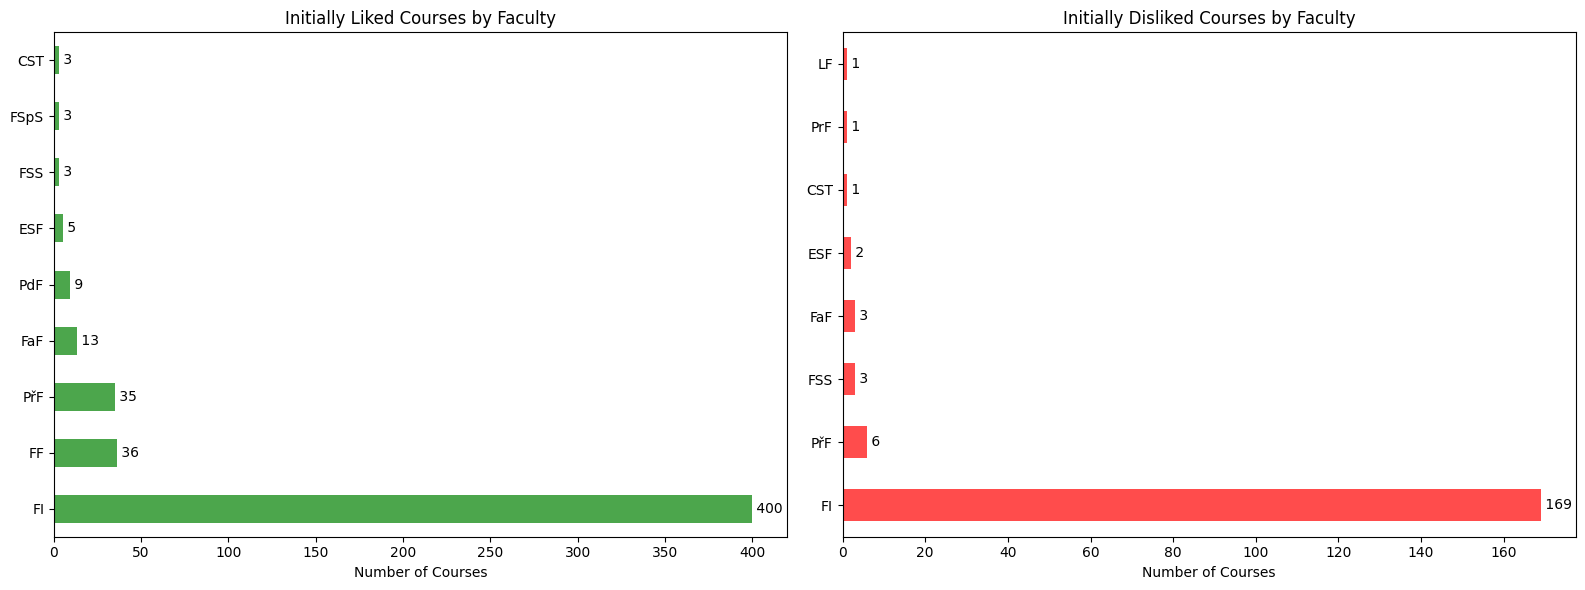


Faculty distribution statistics:
FI     400
FF      36
PřF     35
FaF     13
PdF      9
Name: count, dtype: int64
FI     169
PřF      6
FSS      3
FaF      3
ESF      2
Name: count, dtype: int64


In [235]:
# Get faculty information for initially liked and disliked courses
liked_faculties = []
disliked_faculties = []

# Process liked courses
for course_code, num_likes in initial_likes_counts.items():
    course = course_client.get_course_by_code(course_code)
    if course:
        if not isinstance(course.FACULTY, str):
            continue
        liked_faculties.extend([course.FACULTY] * num_likes)

# Process disliked courses        
for course_code, num_dislikes in initial_dislikes_counts.items():
    course = course_client.get_course_by_code(course_code)
    if course:
        disliked_faculties.extend([course.FACULTY] * num_dislikes)

# Convert to pandas Series and get counts
liked_faculty_counts = pd.Series(liked_faculties).value_counts()
disliked_faculty_counts = pd.Series(disliked_faculties).value_counts()

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6)) 

# Plot liked faculties
liked_faculty_counts.plot(kind='barh', ax=ax1, color='green', alpha=0.7)
ax1.set_title('Initially Liked Courses by Faculty')
ax1.set_xlabel('Number of Courses')

# Add count labels to liked faculties bars
for i, v in enumerate(liked_faculty_counts):
    ax1.text(v, i, f' {v}', va='center')

# Plot disliked faculties
disliked_faculty_counts.plot(kind='barh', ax=ax2, color='red', alpha=0.7)
ax2.set_title('Initially Disliked Courses by Faculty')
ax2.set_xlabel('Number of Courses')

# Add count labels to disliked faculties bars
for i, v in enumerate(disliked_faculty_counts):
    ax2.text(v, i, f' {v}', va='center')

plt.tight_layout()
plt.show()

# Print some statistics
print("\nFaculty distribution statistics:")
print(liked_faculty_counts.head())
print(disliked_faculty_counts.head())



Analyzing most liked and disliked courses...


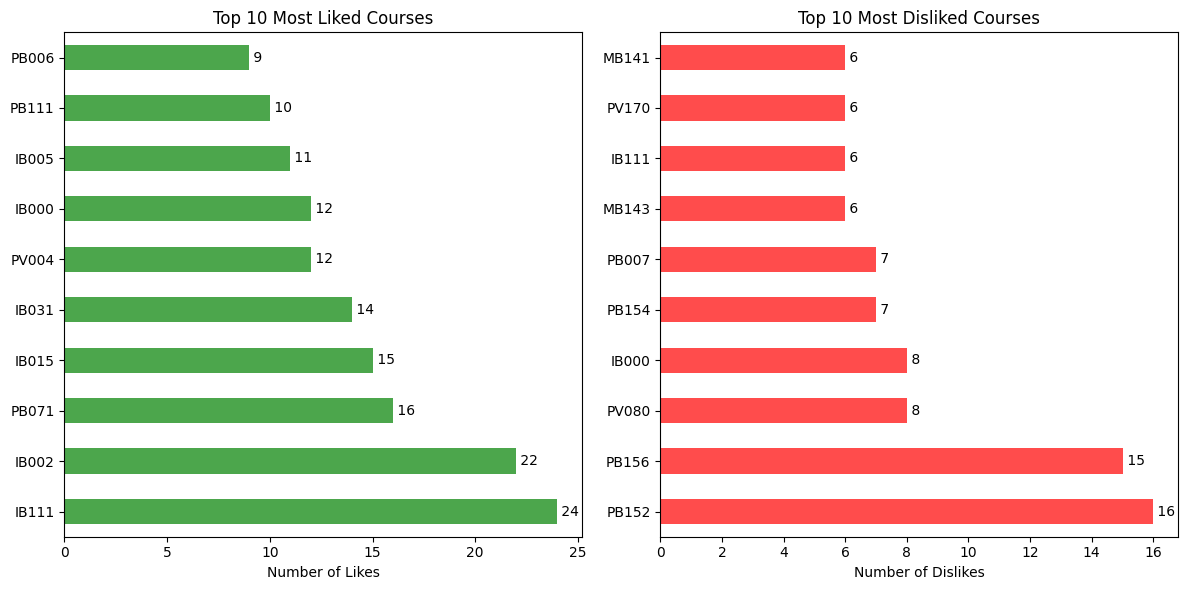


Most liked courses:
IB111 (Základy programování): 24
IB002 (Algoritmy a datové struktury I): 22
PB071 (Principy nízkoúrovňového programování): 16
IB015 (Neimperativní programování): 15
IB031 (Úvod do strojového učení): 14

Most disliked courses:
PB152 (Operační systémy): 16
PB156 (Počítačové sítě): 15
PV080 (Information security and cryptography): 8
IB000 (Matematické základy informatiky): 8
PB154 (Základy databázových systémů): 7


In [236]:
# Analyze most liked and disliked courses
print("\nAnalyzing most liked and disliked courses...")

# Convert to pandas Series and sort
liked_course_counts = pd.Series(initial_likes_counts).sort_values(ascending=False)
disliked_course_counts = pd.Series(initial_dislikes_counts).sort_values(ascending=False)

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot liked courses
liked_course_counts.head(10).plot(kind='barh', ax=ax1, color='green', alpha=0.7)
ax1.set_title('Top 10 Most Liked Courses')
ax1.set_xlabel('Number of Likes')

# Add count labels and course names to liked courses bars
for i, (course, count) in enumerate(liked_course_counts.head(10).items()):
    course_obj = course_client.get_course_by_code(course)
    if course_obj:
        label = f"{course} - {course_obj.NAME[:30]}..." if len(course_obj.NAME) > 30 else f"{course} - {course_obj.NAME}"
        ax1.text(count, i, f' {count}', va='center')
        ax1.set_yticklabels([label for label in ax1.get_yticklabels()])

# Plot disliked courses
disliked_course_counts.head(10).plot(kind='barh', ax=ax2, color='red', alpha=0.7)
ax2.set_title('Top 10 Most Disliked Courses')
ax2.set_xlabel('Number of Dislikes')

# Add count labels and course names to disliked courses bars
for i, (course, count) in enumerate(disliked_course_counts.head(10).items()):
    course_obj = course_client.get_course_by_code(course)
    if course_obj:
        label = f"{course} - {course_obj.NAME[:30]}..." if len(course_obj.NAME) > 30 else f"{course} - {course_obj.NAME}"
        ax2.text(count, i, f' {count}', va='center')
        ax2.set_yticklabels([label for label in ax2.get_yticklabels()])

plt.tight_layout()
plt.show()

# Print statistics
print("\nMost liked courses:")
for code, count in liked_course_counts.head().items():
    course = course_client.get_course_by_code(code)
    print(f"{code} ({course.NAME}): {count}")

print("\nMost disliked courses:") 
for code, count in disliked_course_counts.head().items():
    course = course_client.get_course_by_code(code)
    print(f"{code} ({course.NAME}): {count}")


In [244]:
# Get user feedback data from MongoDB
user_feedbacks = list(db.user_feedback.find())
models = ['max_with_combinations', 'keywords_tfidf']

Analyzing user feedback data...
Total user feedback entries: 65


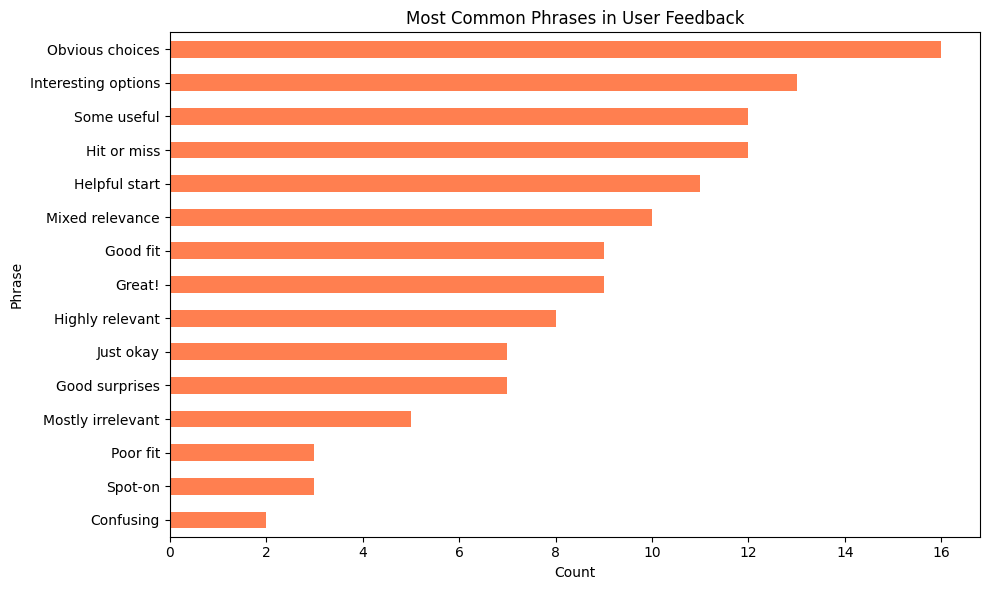

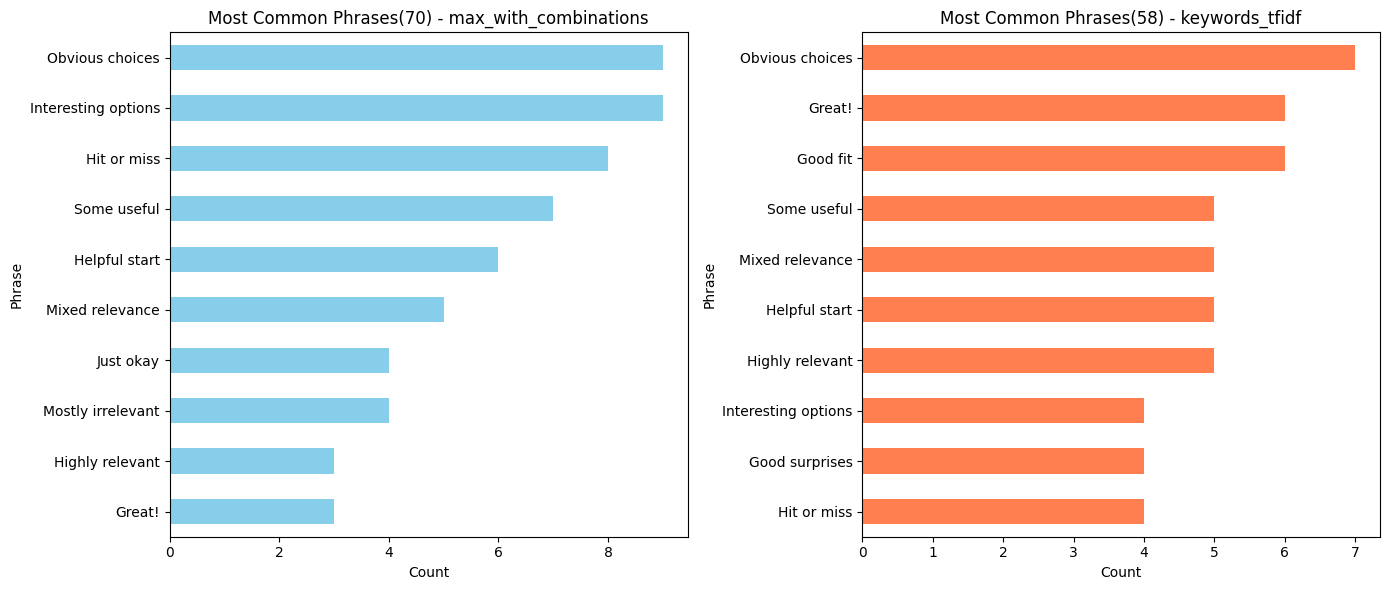

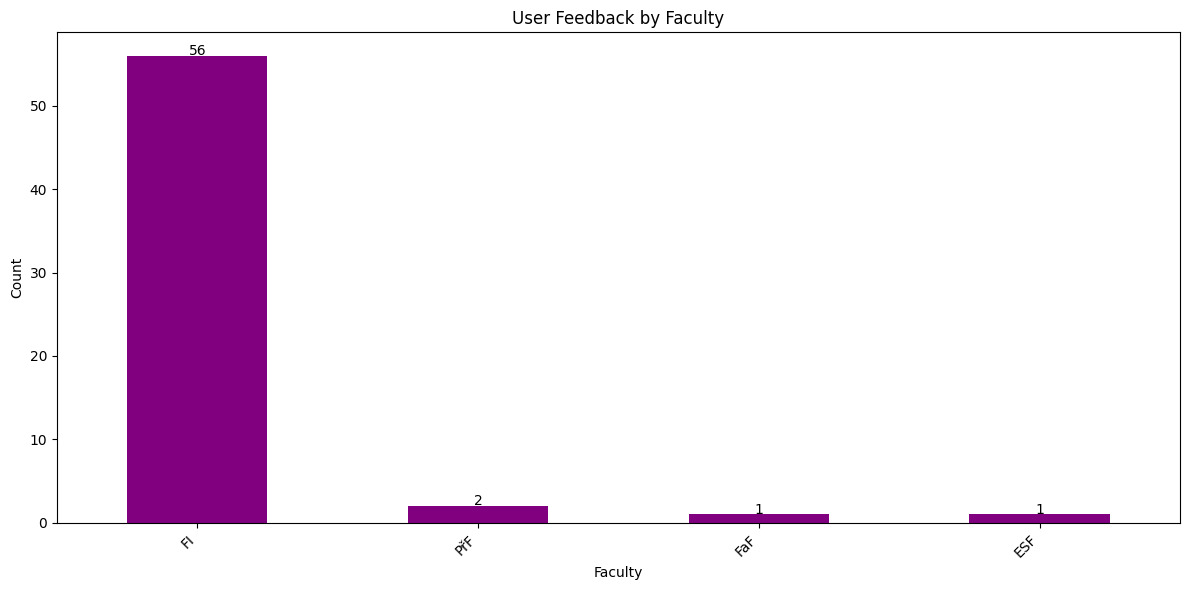

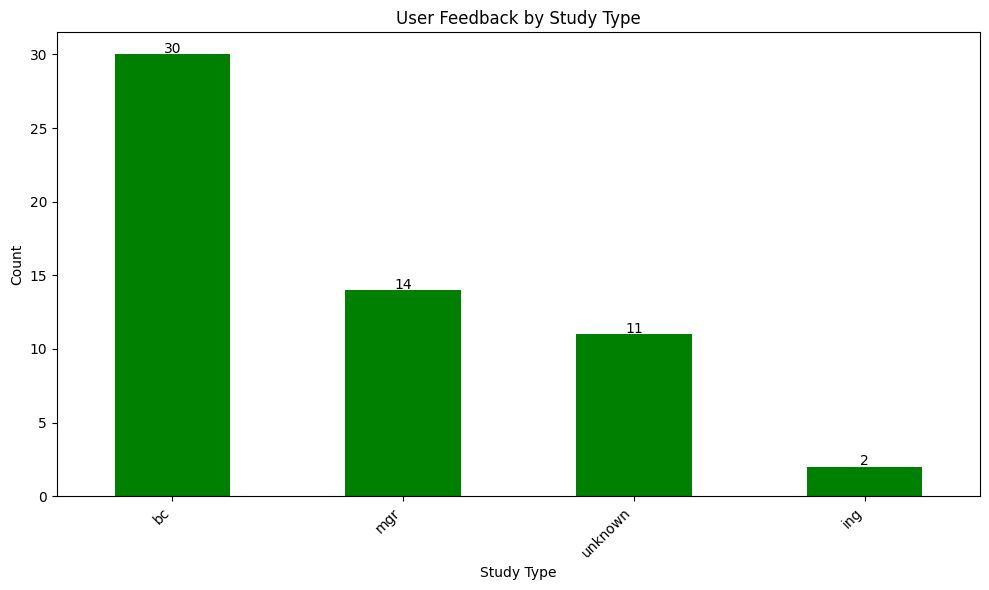

<Figure size 1600x1200 with 0 Axes>

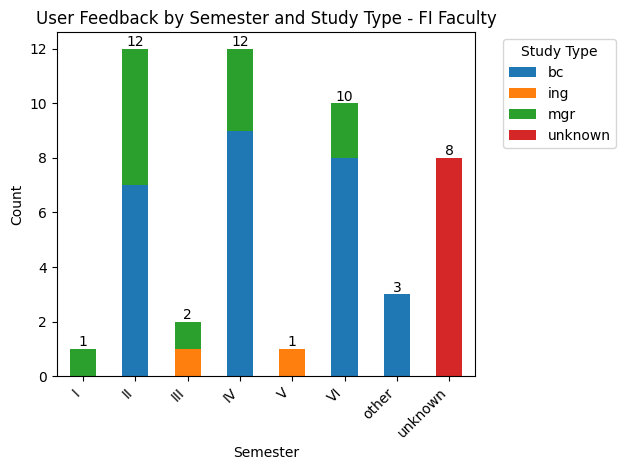


All Feedback Texts:
--------------------------------------------------

Feedback 19da2a3d-7827-4fdc-ac2e-1dcc2f1f97be:
The recomendations locked on one keyword and didnt “experiment” with other things.

--------------------------------------------------

Feedback f0311b03-dd91-4b72-96d3-d5f341befbc4:
banger docela zatim (pouzivam 2 minuty xd)

--------------------------------------------------

Feedback c1ceabe2-f070-4314-8fc5-fded791ece24:
Good job!! From idea to user experience and recommendations!! Consider getting in touch with IS developers. 

--------------------------------------------------

Feedback dd6a23a5-232a-497c-b957-3001e525a262:
😎

--------------------------------------------------

Feedback 24ae16fb-0186-4de8-9fe4-95974090a8af:
La-la-la-lava
Ch-ch-ch-chicken
Steve's Lava Chicken, yeah, it's tasty as hell
Ooh, mamacita, now you're ringing the bell
Crispy and juicy, now you're having a snack
Ooh, super spicy, it's a lava attack!

---------------------------------------

In [250]:
# Analyze user feedback data
print("Analyzing user feedback data...")

feedback_data = []
for feedback in user_feedbacks:
    try:
        feedback_data.append({
            'user_id': feedback['user_id'],
            'model': feedback.get('model', 'unknown'),
            'faculty': feedback.get('faculty', 'unknown'),
            'study_type': feedback.get('study_type', 'unknown'),
            'semester': feedback.get('semester', 'unknown'),
            'phrases': feedback.get('phrases', []),
            'text': feedback.get('text', '')
        })
    except KeyError as e:
        print(f"Missing key in feedback: {e}")
        continue

feedback_df = pd.DataFrame(feedback_data)

print(f"Total user feedback entries: {len(feedback_df)}")

# Analyze common phrases if available
if 'phrases' in feedback_df.columns and not all(x is None or len(x) == 0 for x in feedback_df['phrases']):
    # Flatten the list of phrases
    all_phrases = [phrase for phrases in feedback_df['phrases'] if phrases for phrase in phrases]

    # Overall phrase counts
    phrase_counts = pd.Series(all_phrases).value_counts().head(15)
    plt.figure(figsize=(10, 6))
    ax = phrase_counts.plot(kind='barh', color='coral')
    plt.title('Most Common Phrases in User Feedback')
    plt.xlabel('Count')
    plt.ylabel('Phrase')
    ax.invert_yaxis() 
    plt.tight_layout()
    plt.show()
    
    # Create a dictionary to store phrases by model
    phrases_by_model = {}
    total_sums = {}
    
    # Group feedback by model and collect phrases
    for model, group in feedback_df.groupby('model'):
        model_phrases = [phrase for phrases in group['phrases'] if phrases for phrase in phrases]
        if model_phrases:
            total_sums[model] = pd.Series(model_phrases).value_counts().sum()
            phrases_by_model[model] = pd.Series(model_phrases).value_counts().head(10)
    
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot for first model
    if len(phrases_by_model) > 0:
        first_model = models[0]
        phrases_by_model[first_model].plot(kind='barh', color='skyblue', ax=ax1)
        ax1.set_title(f'Most Common Phrases({total_sums[first_model]}) - {first_model}')
        ax1.set_xlabel('Count')
        ax1.set_ylabel('Phrase')
        ax1.invert_yaxis()
    
    # Plot for second model
    if len(phrases_by_model) > 1:
        second_model = models[1]
        phrases_by_model[second_model].plot(kind='barh', color='coral', ax=ax2)
        ax2.set_title(f'Most Common Phrases({total_sums[second_model]}) - {second_model}')
        ax2.set_xlabel('Count')
        ax2.set_ylabel('Phrase')
        ax2.invert_yaxis()
    
    plt.tight_layout()
    plt.show()

# Analyze feedback by faculty if available
if 'faculty' in feedback_df.columns and not feedback_df['faculty'].isna().all():
    # Replace empty strings with None
    feedback_df['faculty'] = feedback_df['faculty'].replace('', None)
    # Drop None values before counting
    faculty_counts = feedback_df['faculty'].dropna().value_counts()
    faculty_counts = feedback_df['faculty'].value_counts()
    
    plt.figure(figsize=(12, 6))
    ax = faculty_counts.plot(kind='bar', color='purple')
    plt.title('User Feedback by Faculty')
    plt.xlabel('Faculty')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    
    # Add count labels on top of bars
    for i, count in enumerate(faculty_counts):
        plt.text(i, count + 0.1, str(count), ha='center')
    
    plt.tight_layout()
    plt.show()

# Analyze feedback by study type if available
if 'study_type' in feedback_df.columns and not feedback_df['study_type'].isna().all():
    # Replace empty strings with None
    feedback_df['study_type'] = feedback_df['study_type'].replace('', None)
    # Drop None values before counting
    study_type_counts = feedback_df['study_type'].dropna().value_counts()
    
    plt.figure(figsize=(10, 6))
    ax = study_type_counts.plot(kind='bar', color='green')
    plt.title('User Feedback by Study Type')
    plt.xlabel('Study Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    
    # Add count labels on top of bars
    for i, count in enumerate(study_type_counts):
        plt.text(i, count + 0.1, str(count), ha='center')
    
    plt.tight_layout()
    plt.show()

# Analyze feedback by semester and study type for FI faculty only
if 'semester' in feedback_df.columns and 'study_type' in feedback_df.columns and 'faculty' in feedback_df.columns:
    # Replace empty strings with None
    feedback_df['semester'] = feedback_df['semester'].replace('', None)
    feedback_df['study_type'] = feedback_df['study_type'].replace('', None)
    feedback_df['faculty'] = feedback_df['faculty'].replace('', None)
    
    # Filter for FI faculty and drop None values
    fi_data = feedback_df[feedback_df['faculty'] == 'FI'].dropna(subset=['semester', 'study_type'])
    
    # Group by semester and study type
    semester_study_counts = fi_data.groupby(['semester', 'study_type']).size().unstack(fill_value=0)
    
    # Create stacked bar plot
    plt.figure(figsize=(16, 12))
    semester_study_counts.plot(kind='bar', stacked=True)
    plt.title('User Feedback by Semester and Study Type - FI Faculty')
    plt.xlabel('Semester')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Study Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add count labels on top of bars
    for i, semester in enumerate(semester_study_counts.index):
        total = semester_study_counts.loc[semester].sum()
        plt.text(i, total + 0.1, str(total), ha='center')
    
    plt.tight_layout()
    plt.show()


# Print all feedback texts
print("\nAll Feedback Texts:")
print("-" * 50)
for idx, text in enumerate(feedback_df['text'], 1):
    if text is None or text.strip() == "":
        continue
    print(f"\nFeedback {feedback_df['user_id'][idx]}:")
    print(text)
    print()
    print("-" * 50)